In [1]:
import cv2 
import numpy as np
import cv2.aruco as aruco
import sys
sys.path.insert(0, "..")
from eye_hand_calibration import get_board2base_transform
from IPython.display import clear_output
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import time
from websocket import create_connection
import json
import pickle
from dataclasses import dataclass, field
from datetime import datetime
from warnings import warn

In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
stop()

In [15]:
cam_id = "http://100.101.135.89:8080/video"
capture = cv2.VideoCapture(cam_id)
for _ in range(100):
    if capture.isOpened():
        break
    time.sleep(.1)
else:
    raise RuntimeError("Could not connect!")
res = (1920, 1080)
res_x, res_y = res
capture.set(3, res_x)
capture.set(4, res_y)
# for usb cam
# capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"MJPG"))
def stop():
    capture.release()

In [57]:
TILE_SIZE = .2385 / 8
MARKER_SIZE = TILE_SIZE * 0.75


class Camera:

    def __init__(self, tile_size=TILE_SIZE, marker_size=MARKER_SIZE,
                 board_size=(5, 8),):
        self.captured_images = []

        self.dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
        self.parameters = aruco.DetectorParameters()
        self.charuco_params = aruco.CharucoParameters()

        self.tile_size = tile_size
        self.board = aruco.CharucoBoard(board_size, self.tile_size, marker_size,
                                        self.dictionary)
        self.detector = aruco.CharucoDetector(
            self.board, self.charuco_params, self.parameters)

        self.mtx, self.dist = None, None
        self.captured_images = []
        self.last_time = 0

    def add_frame(self, image) -> np.ndarray:
        """
        returns RGBA array of size (x, y, 4)
        """
        image0 = image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        font = cv2.FONT_HERSHEY_SIMPLEX

        cur_corners, cur_ids, _ = self.detector.detectMarkers(image)

        if time.time() - self.last_time < 0.5:
            cv2.circle(image0, (1150, 700), 10, (255, 255, 0),
                       int(np.sin(time.time() - self.last_time) * 40) + 1)
        elif len(cur_corners) >= 19:
            cv2.circle(image0, (1200, 700), 10, (255, 255, 0), 2)
            self.captured_images.append(image0.copy())
            self.last_time = time.time()

        cv2.putText(image0, f"{len(cur_corners):02d}",
                    (64, 64), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        return image0

    def load_coeffs(self):
        self.mtx = np.array([[1.59783241e+03, 0.00000000e+00, 9.59512962e+02],
                             [0.00000000e+00, 1.60387278e+03, 5.59976230e+02],
                             [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
        self.dist = np.array([[4.61332162e-02, -7.10600470e-03, -7.65528458e-05,
                               -5.35365103e-04, -1.26556281e-01]])

    def calibrate(self):
        matched_points = []
        for image in self.captured_images:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cur_corners, cur_ids, *_ = self.detector.detectBoard(image)
            if cur_ids is not None:
                matched_points.append(list(
                    map(np.squeeze, self.board.matchImagePoints(
                        cur_corners, cur_ids.flatten()))
                ))
        obj_points, img_points = zip(*matched_points)
        print(obj_points[1].shape, len(img_points),
              obj_points[0].shape, img_points[0].shape)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            obj_points, img_points, image.shape,
            None, None
        )
        self.mtx = mtx
        self.dist = dist
        print()
        print(self.mtx, self.dist)
        print()

    def process_charuko(self, frame):
        assert self.mtx is not None and self.dist is not None

        frame = frame.copy()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        *_, corners, ids = self.detector.detectBoard(gray)

        if not len(corners):
            font = cv2.FONT_HERSHEY_SIMPLEX
            # cv2.putText(frame, "No Ids", (0,64), font, 1, (0,255,0),2,cv2.LINE_AA)
            return frame, None, None

        # _, rvec_check, tvec_check = aruco.estimatePoseCharucoBoard(
        #     corners_checker, ids_checker,
        #     self.board, self.mtx, self.dist,
        #     None, None
        # )
        try:
            cv2.drawFrameAxes(frame, self.mtx, self.dist,
                              rvec_check, tvec_check, 0.1)
        except:
            pass
        # print(rvec_check, tvec_check)
        aruco.drawDetectedMarkers(frame, corners)
        rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(
            corners, self.tile_size / 2, self.mtx, self.dist)
        # print()
        # print(rvecs[0], tvecs[0])

        for rvec, tvec in zip(rvecs, tvecs):
            cv2.drawFrameAxes(frame, self.mtx, self.dist, rvec, tvec, 0.01)

        return frame, rvec_check, tvec_check

In [5]:
def get_pos():
    req = {"command": "get_xyz", "args":[], "kwargs":{}}
    data = json.dumps(req)
    ws = create_connection("ws://localhost:9001")
    ws.send(data)
    res = json.loads(ws.recv())
    ws.close()
    return res

In [6]:
@dataclass
class Entry:
    # raw data
    img: np.ndarray
    xyz: np.ndarray
    rvec: np.ndarray
    tvec: np.ndarray
    # processed with camera
    img_with_charuco: np.ndarray
    # found out automatically
    end_effector_pos: np.ndarray = None
    cam_to_checker: np.ndarray = None
    
    def __post_init__(self):
        self.xyz = np.array(self.xyz)
        self.end_effector_pos = self.get_ef()
        self.cam_to_checker = self.get_twist(cv2.Rodrigues(self.rvec)[0], self.tvec)
    
    def get_ef(self):
        x, y, z = self.xyz / 1000
        alpha = np.arctan2(y, x)
        matrix = np.array([[np.sin(alpha), 0, np.cos(alpha), x],
                           [-np.cos(alpha), 0, -np.sin(alpha), y],
                           [0, 1, 0, z],
                           [0, 0, 0, 1]])
        return matrix
    
    @staticmethod
    def get_twist(R, p):
        return np.block([[R, p.reshape(-1, 1)], [0] * len(p) + [1]])

@dataclass
class Experiment:
    dir_path: str | Path
    entries: list[Entry] = field(default_factory=list)
    path: Path = None
    
    def __post_init__(self):
        self.dir_path = Path(self.dir_path)
        if not self.dir_path.exists():
            self.dir_path.mkdir(parents=True)
        self.path = self.dir_path / datetime.now().strftime("%m-%d_(%h)_%H:%M")
        
    
    def append(self, entry: Entry):
        self.entries.append(entry)
        with self.path.open("wb") as f:
            pickle.dump(self, f)
    
    def load_last(self):
        return max(self.dir_path.iterdir(),
                   key=lambda path: path.name)


In [7]:
def _stream(calibr: Camera, experiment: Experiment, showing_res=(1280, 720)):
    displaying_aruco = False
    while True:
        _, cam_img = capture.read()
        # if cam_img is None:
        #     continue
        if not displaying_aruco:
            to_show = cam_img
        else:
            to_show = calibr.process_charuko(cam_img.copy())[0]
        cv2.imshow('w', cv2.resize(to_show, showing_res))
        
        if (key := cv2.waitKey(1)) == ord("q"):
            break
        elif key == ord("n"):
            displaying_aruco = not displaying_aruco
        elif key in [ord("f"), ord("t")]:
            _, rvec, tvec = calibr.process_charuko(cam_img.copy())
            xyz = get_pos()["result"]
            experiment.append(Entry(img=cam_img,
                                    xyz=xyz, rvec=rvec, tvec=tvec,
                                    img_with_charuco=calibr.process_charuko(cam_img.copy())[0]))
            print(xyz)
        
        
def stream(calibr, experiment: Experiment | None = None):
    if experiment is None:
        warn("No experiment provided!")
        experiment = Experiment("./t")
        
    try:
        _stream(calibr, experiment)
    finally:
        cv2.destroyAllWindows()
    print(len(experiment.entries))

In [58]:
calibr = Camera(board_size=(5, 8))
calibr.load_coeffs()

In [36]:
exp = Experiment("exps/1")

In [ ]:
stream(calibr, exp)

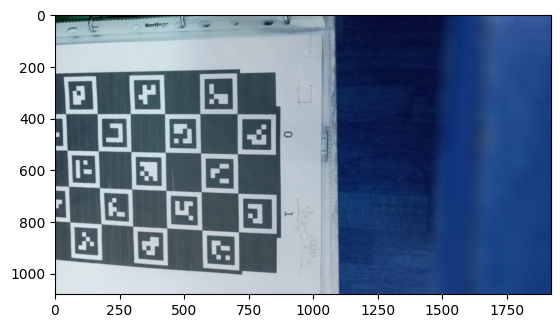

In [16]:
_, img = capture.read()
plt.imshow(img)

In [59]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
a, b, corners, ids = calibr.detector.detectBoard(gray)

In [20]:
markerLength = MARKER_SIZE
obj_points = np.array([
    [-markerLength/2, markerLength, 0],
    [markerLength/2, markerLength, 0],
    [markerLength/2, -markerLength, 0],
    [-markerLength/2, -markerLength, 0]
])

In [60]:
c, d = calibr.board.matchImagePoints(a, b)

In [61]:
_, rvec_board, tvec_board = cv2.solvePnP(c, d, calibr.mtx, calibr.dist)

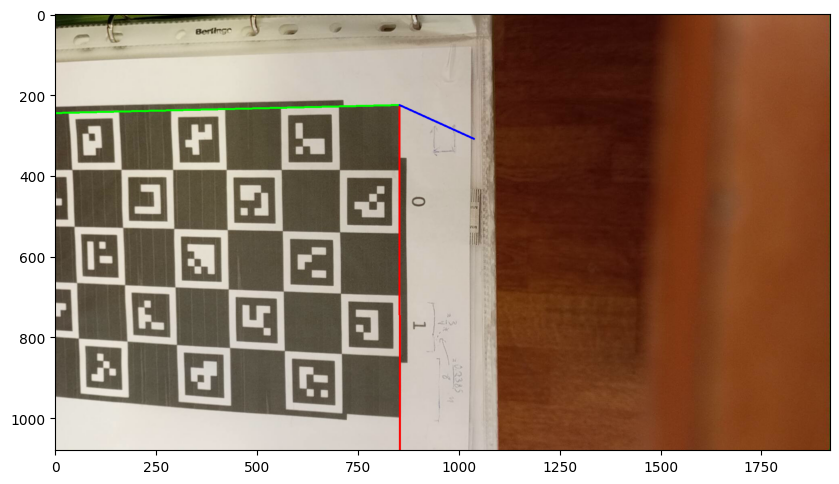

In [64]:
t = img.copy()
plt.figure(figsize=(10, 10))
cv2.drawFrameAxes(t, calibr.mtx, calibr.dist, rvec_board, tvec_board, 0.2)
plt.imshow(t[..., ::-1])

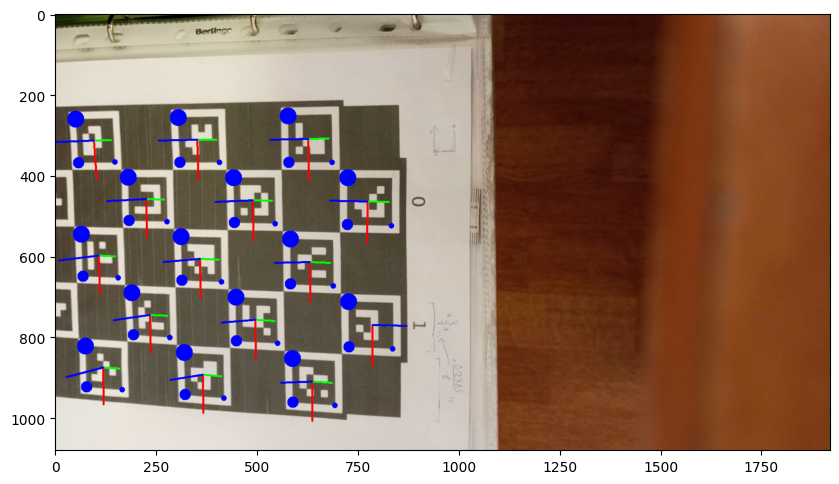

In [21]:
t = img.copy()
plt.figure(figsize=(10, 10))
for i in range(len(corners)):
    for j, pos in enumerate(corners[i][0]):
        cv2.circle(t, pos.astype(int), 7 * j, [255, 0, 0], -1)
        
    _, rvec, tvec = cv2.solvePnP(obj_points, corners[i], calibr.mtx, calibr.dist)
    cv2.drawFrameAxes(t, calibr.mtx, calibr.dist, rvec, tvec, 0.02)
plt.imshow(t[..., ::-1])

In [60]:
a[0, 0]


array([1261.0741 ,  463.08484], dtype=float32)

In [143]:
with open("data_2.pickle", "rb") as f:
    data = pickle.load(f)
    raw_data = data["raw_data"]
    cam_to_checkers = data["cam_to_checkers"]
    chars = data["chars"]

end_effector_poses = []
for dat in raw_data:
    xyz = dat["xyz"]
    x, y, z = np.array(xyz) / 1000
    phi = np.arctan2(y, x)
    T = np.array([
        [np.cos(phi), np.sin(phi), 0, x],
        [np.sin(phi), -np.cos(phi), 0, y],
        [0, 0, -1, z],
        [0, 0, 0, 1],
    ])
    end_effector_poses.append(T)

In [141]:
t = get_board2base_transform(end_effector_poses, cam_to_checkers)
t

0.9999999999999999 0.9995207223418541
tsnei [-3.14111402  0.01057899 -0.04223592]


array([[-0.96783635, -0.25122416,  0.33147524],
       [-0.25125149,  0.96792177, -0.02793075],
       [ 0.        ,  0.        ,  1.        ]])

In [134]:
t = get_board2base_transform(end_effector_poses, cam_to_checkers)
np.linalg.inv(t) @ np.array([.045, .045, 1])

1.0 0.9998889488261827
tsnei [-3.13377405  0.00805668 -0.04592483]


array([0.2652634, 0.1471396, 1.       ])

In [105]:
np.array(get_pos()["result"]) / 1000

array([ 0.26742932, -0.0395747 , -0.06101032])